# This version uses the GreenStream data
These samples were removed in try 3 since it has so much missing data for precipitation.  So here no data (USGS or GSVB) is removed.  Instead average amounts were added for daily readings.   In other words, try 6 has been modified to use data thrown out in Try3.

In [1]:
%load_ext tensorboard.notebook

In [2]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import os.path


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(tf.__version__)

2.0.0-alpha0


In [4]:
# google collab version
#CSV_FILE_NAME = "usgs_gsvb_v2.csv"
# jupyter notebook version
CSV_FILE_NAME = "../csv/usgs_gsvb_v2.csv"
os.environ['CSV_FILE_NAME'] = CSV_FILE_NAME

In [5]:
# The current directory will be where this src file is located.
# Which is in the src dir of the project
dirpath = os.getcwd()
print("current directory is : " + dirpath)

current directory is : /home/davis/progs/tf-hackathon/src


In [6]:
root_path = os.path.dirname(dirpath)
print("parent directory is : " + root_path)

parent directory is : /home/davis/progs/tf-hackathon


In [7]:
logs_path = os.path.join(root_path,"logs")
print("logs directory is : " + logs_path)

logs directory is : /home/davis/progs/tf-hackathon/logs


In [8]:
LOG_DIR_NAME = logs_path
os.environ['LOG_DIR_NAME'] = LOG_DIR_NAME

In [9]:
%%bash
echo ${LOG_DIR_NAME}

/home/davis/progs/tf-hackathon/logs


In [10]:
%%bash
head ${CSV_FILE_NAME}

usgs,site_no,date,tidal_high,tidal_low,precipitation_inches,lat,long
GSVB,33670001,2019-03-08,-6.7913385826771648,-6.7257217847769031,,36.735303,-76.011602
GSVB,33670001,2019-03-19,-6.8569553805774275,-6.758530183727034,,36.735303,-76.011602
GSVB,33670001,2019-02-21,1.9356955380577427,2.1325459317585302,,36.735303,-76.011602
GSVB,33670001,2019-03-11,-6.66010498687664,-6.4304461942257216,,36.735303,-76.011602
GSVB,33670001,2019-04-04,1.9028871391076114,2.0669291338582676,,36.735303,-76.011602
GSVB,33670001,2019-02-14,1.7716535433070866,1.9356955380577427,,36.735303,-76.011602
GSVB,33670001,2019-04-14,2.2309711286089238,2.39501312335958,,36.735303,-76.011602
GSVB,33670001,2019-02-24,2.65748031496063,2.9527559055118111,,36.735303,-76.011602
GSVB,33670001,2019-01-12,2.2965879265091864,2.39501312335958,,36.735303,-76.011602


In [11]:
%%bash
# this csv file has 9875 lines corresponding to records (plus one header row)
wc -l ${CSV_FILE_NAME}

9876 ../csv/usgs_gsvb_v2.csv


# Use generic python to read data into pandas dataframe

## In order to add default values for missing data, use the converters helper functions

In [15]:
# Create a function to look for nans in the dataframe
# call via nans(dataset)
nans = lambda df: df[df.isnull().any(axis=1)]

In [16]:
# Anytime there is missing data for high tide column, use the default value of 1.2
def default_tidal_high(cell_value):
    # print(type(cell_value))
    # print("value is {}".format(cell_value))
    
    # Input cell values are strings
    # The blanks for missing values are litteral blanks
    try:
        ret_value = float(cell_value)
        return ret_value
    except:
        # Average of available data
        return float(1.2)
        
    return cell_value       

In [17]:
def default_tidal_low(cell_value):
    # print(type(cell_value))
    # print("value is {}".format(cell_value))
    
    # Input cell values are strings
    # The blanks for missing values are litteral blanks
    try:
        ret_value = float(cell_value)
        return ret_value
    except:
        # Average of available data
        return float(-0.89)
        
    return cell_value       

In [18]:
def default_precipitation(cell_value):
    # print(type(cell_value))
    # print("value is {}".format(cell_value))
    
    # Input cell values are strings
    # The blanks for missing values are litteral blanks
    try:
        ret_value = float(cell_value)
        return ret_value
    except:
        # the average rainfall divided by 365.
        return float(0.117)
        
    return cell_value       

In [19]:
raw_dataset = pd.read_csv(CSV_FILE_NAME, 
                          header=0,
                          parse_dates=[2],
                          converters={'precipitation_inches':default_precipitation, 
                                      'tidal_high':default_tidal_high,
                                      'tidal_low': default_tidal_low},
                          sep=",")

dataset = raw_dataset.copy()

## In order to add default values for missing data, use the converters helper functions

In [20]:
# This should show an empty set
nans(dataset)

,usgs,site_no,date,tidal_high,tidal_low,precipitation_inches,lat,long


In [21]:
dataset.dropna(inplace=True)
nans(dataset)

,usgs,site_no,date,tidal_high,tidal_low,precipitation_inches,lat,long


In [22]:
dataset.shape
#dataset.head()

(9875, 8)

In [23]:
# drop any columns which we will not use
dataset.drop(['usgs','tidal_low','site_no'], axis=1, inplace=True)
dataset.head()

,date,tidal_high,precipitation_inches,lat,long
0,2019-03-08,-6.791339,0.117,36.735303,-76.011602
1,2019-03-19,-6.856955,0.117,36.735303,-76.011602
2,2019-02-21,1.935696,0.117,36.735303,-76.011602
3,2019-03-11,-6.660105,0.117,36.735303,-76.011602
4,2019-04-04,1.902887,0.117,36.735303,-76.011602


# Create new columns for year, month, day from the date column

In [24]:
def create_ymd_cols(df, column):
    df[column + "_year"] = df[column].apply(lambda x: x.year)
    df[column + "_month"] = df[column].apply(lambda x: x.month)
    df[column + "_day"] = df[column].apply(lambda x: x.day)
    
create_ymd_cols(dataset, 'date')

In [25]:
dataset.head()

,date,tidal_high,precipitation_inches,lat,long,date_year,date_month,date_day
0,2019-03-08,-6.791339,0.117,36.735303,-76.011602,2019,3,8
1,2019-03-19,-6.856955,0.117,36.735303,-76.011602,2019,3,19
2,2019-02-21,1.935696,0.117,36.735303,-76.011602,2019,2,21
3,2019-03-11,-6.660105,0.117,36.735303,-76.011602,2019,3,11
4,2019-04-04,1.902887,0.117,36.735303,-76.011602,2019,4,4


In [26]:
# remove the date column
dataset.pop('date')
dataset.head()

,tidal_high,precipitation_inches,lat,long,date_year,date_month,date_day
0,-6.791339,0.117,36.735303,-76.011602,2019,3,8
1,-6.856955,0.117,36.735303,-76.011602,2019,3,19
2,1.935696,0.117,36.735303,-76.011602,2019,2,21
3,-6.660105,0.117,36.735303,-76.011602,2019,3,11
4,1.902887,0.117,36.735303,-76.011602,2019,4,4


In [27]:
train_ds = dataset.sample(frac=0.7,random_state=3367)
leftover_ds = dataset.drop(train_ds.index)
test_ds = leftover_ds.sample(frac=0.5, random_state=3367)
valid_ds = leftover_ds.drop(test_ds.index)

In [28]:
# Create seperate series/dataframe? for labels
# Remove the label from the dataframes.
train_labels = train_ds.pop('tidal_high')
test_labels = test_ds.pop('tidal_high')
valid_labels = valid_ds.pop('tidal_high')

# Normalize the data

In [29]:
# use only the training data to get mean and std 
# which we can use to norm all datasets
train_stats_df = train_ds.copy()
train_stats = train_stats_df.describe().transpose()


In [30]:
def norm(a_df):
    # Do the norm operation
    normed_df = (a_df - train_stats['mean']) / train_stats['std']
    return normed_df

normed_train_ds = norm(train_ds)
normed_test_ds = norm(test_ds)
normed_valid_ds = norm(valid_ds)

In [31]:
#normed_train_ds
normed_valid_ds.head()

,precipitation_inches,lat,long,date_year,date_month,date_day
19,-0.031107,-0.869075,0.677893,1.540909,-1.467756,1.611953
21,-0.031107,-0.869075,0.677893,1.540909,-1.467756,-1.330050
24,-0.031107,-0.869075,0.677893,1.540909,-0.900735,-1.330050
25,-0.031107,-0.869075,0.677893,1.540909,-0.900735,0.480413
38,-0.031107,-0.869075,0.677893,1.540909,-1.467756,0.706721


# Build the model

In [32]:
# train_ds determines the input feature size
model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_ds.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
    ])

# orig
#optimizer = tf.keras.optimizers.RMSprop(0.001)
# increase learning rate if fairly consistent but slow changing
#optimizer = tf.keras.optimizers.RMSprop(0.01)
# 0.1 is too big
#optimizer = tf.keras.optimizers.RMSprop(0.1)
# with the early stop, lets try to make the learning rate smaller
optimizer = tf.keras.optimizers.RMSprop(0.0001)

# Add in the early stop code
# The patience parameter is the amount of epochs to check for improvement
#
# NOTE: This was a good addition.  I'm so used to running through a lot of steps
# I did not realize that it was finding its best results so early.  In the 
# graphs that follows, you can see the divergent graphs here where the others
# did not show it since it was hundreds of epochs past optimal.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])


# Train the model (with three callbacks)

In [33]:
EPOCHS = 1000

In [34]:
%%bash
# clear any logs from previous runs
rm -rf ${LOG_DIR_NAME}

In [35]:
logdir = os.path.join(LOG_DIR_NAME, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
print(logdir)

/home/davis/progs/tf-hackathon/logs/20190506-181337


In [36]:
os.environ['LOG_DIR_NAME_TIME_VARIABLE'] = logdir

In [37]:
# cell magic is weird on how to evaluate this
# this works since its hard coded but not time variable
#%tensorboard --logdir '/home/davis/progs/tf-hackathon/logs'
# ps auxw | grep tensorboard show this as literal --logdir logdir
#%tensorboard --logdir logdir
# ps auxw | grep tensorboard show this as literal --logdir $/home/davis/....
#%tensorboard --logdir ${LOG_DIR_NAME}
# ps auxw | grep tensorboard show this as literal --logdir /home/davis/...
# this works because it finds tf events in root down
#%tensorboard --logdir {LOG_DIR_NAME}
# this does not work.  ps auxw shows tensorboard --logdir {LOG_DIR_NAME_TIME_VARIABLE}
#%tensorboard --logdir {LOG_DIR_NAME_TIME_VARIABLE}
# this works best. it shows up in tensorboard with time variable. tensorboard --logdir /home/davis/progs/tf-hackathon/logs/20190506-115136
%tensorboard --logdir {logdir}

Wait a bit until the above pane shows the blank tensorboard page before running the cell below

In [38]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [39]:
#                    batch_size=16,

history = model.fit(normed_train_ds, 
                    train_labels,
                    epochs=EPOCHS,
                    validation_data = (normed_valid_ds, valid_labels),
                    verbose=0,
                    callbacks=[early_stop, tensorboard_callback, PrintDot()])


....................................................................................................
....................................................................................................
............

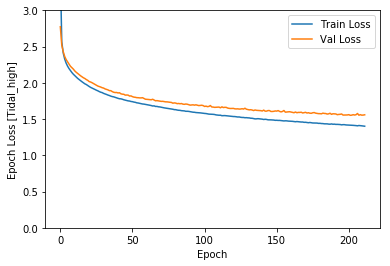

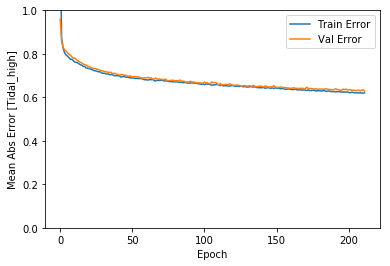

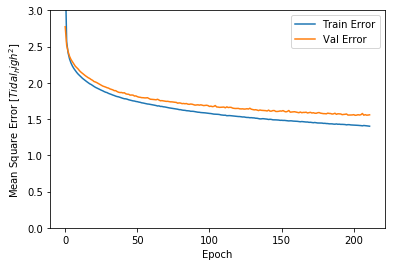

In [48]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Epoch Loss [Tidal_high]')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.ylim([0,3])
    plt.legend()


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Tidal_high]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Tidal_high^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [50]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,3.543652,1.262222,3.543653,2.773993,0.959025,2.773993,0
1,2.565893,0.872426,2.565893,2.520181,0.855623,2.520181,1
2,2.413383,0.826554,2.413383,2.430734,0.830454,2.430735,2
3,2.330078,0.806224,2.330078,2.365609,0.818543,2.365609,3
4,2.273433,0.794730,2.273433,2.321889,0.813909,2.321889,4
5,2.231273,0.789889,2.231274,2.289749,0.805260,2.289749,5
6,2.197396,0.782518,2.197397,2.259538,0.797164,2.259538,6
7,2.169190,0.775931,2.169190,2.229079,0.793783,2.229079,7
8,2.142666,0.774503,2.142665,2.209147,0.787204,2.209146,8
9,2.119494,0.769826,2.119494,2.189762,0.779339,2.189762,9


Now we are getting reasonable results.  Using a smaller learning rate, with an early stop callback.

# Evauate model
Note by including the data with missing values and adding in average amounts increased the error.

In [51]:
loss, mae, mse = model.evaluate(normed_test_ds, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} predicted water level high in feet".format(mae))

Testing set Mean Abs Error:  0.61 predicted water level high in feet


# Make predictions

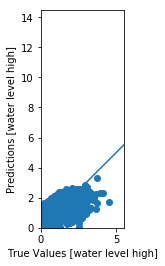

In [52]:
test_predictions = model.predict(normed_test_ds).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [water level high]')
plt.ylabel('Predictions [water level high]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Look at error distribution

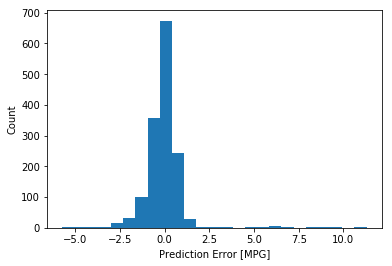

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Adding back the license since this was taken largerly from his example code.

In [61]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.